In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.Grayscale(3),    
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

# Load Fashion-MNIST dataset
fashion_mnist_trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_mnist_testset = datasets.FashionMNIST(root='./data', train=False, transform=transform)


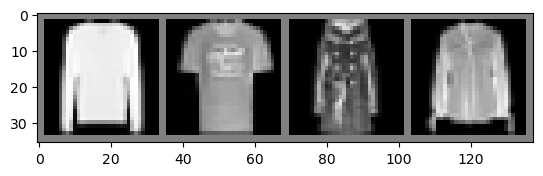

In [4]:
import matplotlib.pyplot as plt
import torchvision

def imshow(img):
    img = img.mean(dim=0)  
    plt.imshow(img, cmap='gray')
    plt.show()

dataiter = iter(DataLoader(fashion_mnist_trainset, batch_size=4, shuffle=True))
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))


In [5]:
# Splitting the dataset
train_size = int(0.9 * len(fashion_mnist_trainset))
val_size = len(fashion_mnist_trainset) - train_size
fashion_train, fashion_val = random_split(fashion_mnist_trainset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(fashion_train, batch_size=32, shuffle=True)
val_loader = DataLoader(fashion_val, batch_size=32, shuffle=False)


In [6]:
import torch.nn as nn
from torchvision.models import resnet18

class SimResNet(nn.Module):
    def __init__(self):
        super(SimResNet, self).__init__()
        original_resnet = resnet18(pretrained=True)
        self.features = nn.Sequential(*list(original_resnet.children())[:-4])  # Use fewer layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(128, 10)  # Final classifier for 10 classes

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = SimResNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

Epoch 1 training loss: 0.3755040477753851
Epoch 1 validation loss: 0.26999033091867225
Epoch 2 training loss: 0.24963871092244241
Epoch 2 validation loss: 0.2570373746269244
Epoch 3 training loss: 0.2180470105578408
Epoch 3 validation loss: 0.22565013492242136
Epoch 4 training loss: 0.19292262114663894
Epoch 4 validation loss: 0.24110858269194338
Epoch 5 training loss: 0.1720103482225848
Epoch 5 validation loss: 0.23658684879898073
Epoch 6 training loss: 0.15436594207606708
Epoch 6 validation loss: 0.226722947896478
Epoch 7 training loss: 0.1395226265629312
Epoch 7 validation loss: 0.2120396785903722
Epoch 8 training loss: 0.12263622112937439
Epoch 8 validation loss: 0.21949056321953206
Epoch 9 training loss: 0.10908112276242869
Epoch 9 validation loss: 0.23113994559451462
Epoch 10 training loss: 0.09524993778146269
Epoch 10 validation loss: 0.23088474367111128
Epoch 11 training loss: 0.08514589783534882
Epoch 11 validation loss: 0.24687644484591612
Epoch 12 training loss: 0.0757772273

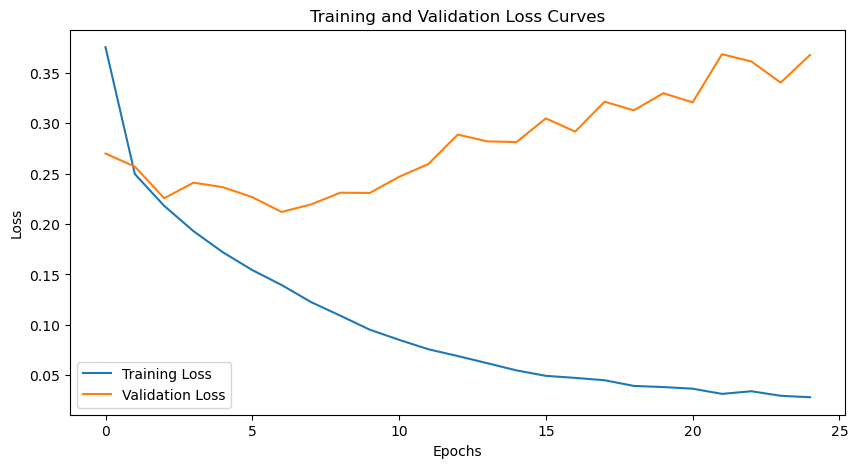

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(25):  
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1} training loss: {running_loss / len(train_loader)}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch + 1} validation loss: {val_loss / len(val_loader)}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total}%')

test_loader = DataLoader(fashion_mnist_testset, batch_size=32, shuffle=False)
predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

print(predictions[:10])  


Accuracy of the network on the validation images: 92.61666666666666%
[9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
